In [1]:
#code for generating the randome state, by generating 300 student id's, and their sum of digits, and then summing all the sum of digits to find the random state
import random
import csv

def generate_student_id():
    return str(random.randint(211000, 212000))

def sum_of_digits(number):
    return sum(int(digit) for digit in str(number))

unique_student_ids = set()
while len(unique_student_ids) < 300:
    base_id = generate_student_id()
    unique_student_ids.add(base_id)

student_ids = list(unique_student_ids)
random.shuffle(student_ids)

sums_of_digits = [sum_of_digits(int(student_id)) for student_id in student_ids]

for i in range(len(student_ids)):
    print(f"{i+1}- {student_ids[i]}, Sum of Digits: {sums_of_digits[i]}")

total_sum = sum(sums_of_digits)

csv_file_name = "output.csv"
with open(csv_file_name, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Student ID", "Sum of Digits"])

    for i in range(len(student_ids)):
        csv_writer.writerow([student_ids[i], sums_of_digits[i]])

    csv_writer.writerow(["Total Sum of Digits", total_sum])

print(f"CSV file '{csv_file_name}' has been generated.")

1- 211420, Sum of Digits: 10
2- 211980, Sum of Digits: 21
3- 211749, Sum of Digits: 24
4- 211080, Sum of Digits: 12
5- 211173, Sum of Digits: 15
6- 211525, Sum of Digits: 16
7- 211571, Sum of Digits: 17
8- 211438, Sum of Digits: 19
9- 211546, Sum of Digits: 19
10- 211033, Sum of Digits: 10
11- 211970, Sum of Digits: 20
12- 211315, Sum of Digits: 13
13- 211127, Sum of Digits: 14
14- 211161, Sum of Digits: 12
15- 211376, Sum of Digits: 20
16- 211103, Sum of Digits: 8
17- 211139, Sum of Digits: 17
18- 211057, Sum of Digits: 16
19- 211682, Sum of Digits: 20
20- 211686, Sum of Digits: 24
21- 211337, Sum of Digits: 17
22- 211371, Sum of Digits: 15
23- 211889, Sum of Digits: 29
24- 211857, Sum of Digits: 24
25- 211008, Sum of Digits: 12
26- 211816, Sum of Digits: 19
27- 211648, Sum of Digits: 22
28- 211395, Sum of Digits: 21
29- 211893, Sum of Digits: 24
30- 211803, Sum of Digits: 15
31- 211610, Sum of Digits: 11
32- 211929, Sum of Digits: 24
33- 211600, Sum of Digits: 10
34- 211265, Sum of D

In [4]:
#Libraries 
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import f1_score, normalized_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 

In [5]:
#Kmeans class
class KMeans:
    def __init__(self, k=5, max_iter=100, plot_steps=False): #0
        self.k = k
        self.max_iter = max_iter
        self.plot_steps = plot_steps

    def initialize_centroids(self, X): #1
        n_samples, n_features = X.shape
        centroids = X[np.random.choice(range(n_samples), self.k, replace=False)]
        return centroids

    def assign_clusters(self, centroids, X): #2
        distances = cdist(X, centroids, metric='euclidean')
        cluster_assignment = np.argmin(distances, axis=1)
        return cluster_assignment

    def compute_centroids(self, cluster_assignment, X): #3
        centroids = np.array([np.mean(X[cluster_assignment == i], axis=0) for i in range(self.k)])
        return centroids

    def fit(self, X): #5
        centroids = self.initialize_centroids(X)
        for _ in range(self.max_iter):
            cluster_assignment = self.assign_clusters(centroids, X)
            centroids = self.compute_centroids(cluster_assignment, X)
            if self.plot_steps:
                self.plot(X, centroids, cluster_assignment)
        self.cluster_assignment_ = cluster_assignment
        self.centroids_ = centroids

    def plot(self, X, centroids, cluster_assignment): #4   
        plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, s=50)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
        plt.show()

In [6]:
#GMM class
class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-4):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape

        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]  

        self.covariances = np.array([np.cov(X.T) for _ in range(self.n_components)])

        self.weights = np.full(self.n_components, 1.0 / self.n_components)

    def compute_likelihood(self, X):
        likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            diff = X - self.means[k]
            exponent = np.sum(np.linalg.solve(self.covariances[k], diff.T).T * diff, axis=1)
            likelihood[:, k] = np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.covariances[k]))
        return likelihood

    def expectation_step(self, X):
        likelihood = self.compute_likelihood(X)
        weighted_likelihood = likelihood * self.weights
        responsibilities = weighted_likelihood / np.sum(weighted_likelihood, axis=1, keepdims=True)
        return responsibilities

    def maximization_step(self, X, responsibilities):
        Nk = np.sum(responsibilities, axis=0)
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot((responsibilities[:, k, np.newaxis] * diff).T, diff) / Nk[k]
        self.weights = Nk / np.sum(Nk)

    def fit(self, X):
        self.initialize_parameters(X)
        for iteration in range(self.max_iters):
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            log_likelihood = np.sum(np.log(np.sum(self.compute_likelihood(X) * self.weights, axis=1)))
            if iteration > 0 and np.abs(log_likelihood - self.prev_log_likelihood) < self.tol:
                break
            self.prev_log_likelihood = log_likelihood

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)

In [7]:
#Measures calculating function
def calculate_accuracy(y_true, predictions):
    f_measure = f1_score(y_true, predictions, average='weighted')
    nmi = normalized_mutual_info_score(y_true, predictions)
    rand_statistic = adjusted_rand_score(y_true, predictions)
    return f_measure, nmi, rand_statistic

In [8]:
#Plot functions for Kmeans and GMM
def plot_kmeans_clusters(kmeans, X, title):
    kmeans.fit(X)
    cluster_assignment = kmeans.cluster_assignment_
    centroids = kmeans.centroids_

    plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100)
    plt.title(title)
    plt.show()

def plot_gmm_clusters(gmm, X, title):
    gmm.fit(X)
    predictions = gmm.predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap='viridis')
    plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='x', s=100, label='Centroids')
    plt.title(title)
    plt.legend()
    plt.show()

In [21]:
#Datasets section
random_state = 5274
n_samples = 300

#blobs dataset
X_blobs, y_blobs = make_blobs(n_samples=n_samples, random_state=random_state)

#Anisotropically distributed dataset
X_anisotropic, _ = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_anisotropic = np.dot(X_anisotropic, transformation)

#Noisy moons dataset
X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)

#Noisy circles dataset
X_circles, y_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=random_state)

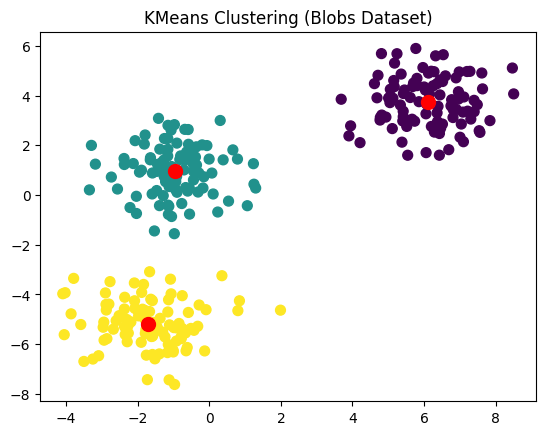

In [22]:
#Kmeans clustering for blobs dataset
kmeans_blobs = KMeans(k=3, max_iter=100, plot_steps=False)
plot_kmeans_clusters(kmeans_blobs, X_blobs, 'KMeans Clustering (Blobs Dataset)')

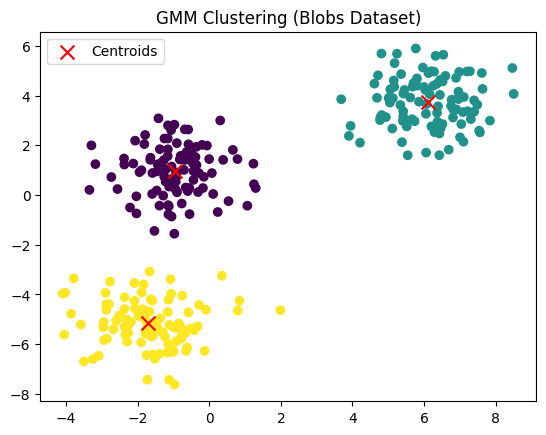

In [23]:
#GMM clustering for blobs dataset
gmm_blobs = GMM(n_components=3)
plot_gmm_clusters(gmm_blobs, X_blobs, 'GMM Clustering (Blobs Dataset)')

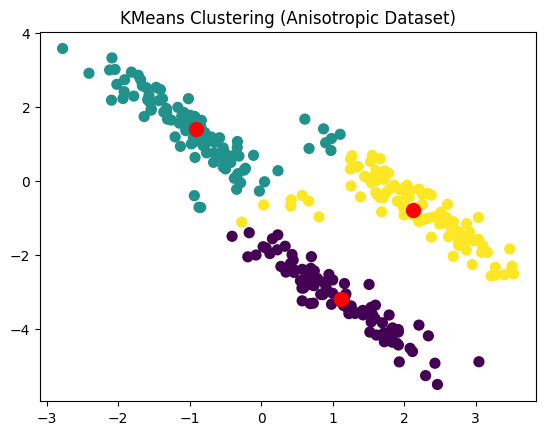

In [24]:
#Kmeans clustering for anisotropic dataset
kmeans_anisotropic = KMeans(k=3, max_iter=100, plot_steps=False)
plot_kmeans_clusters(kmeans_anisotropic, X_anisotropic, 'KMeans Clustering (Anisotropic Dataset)')

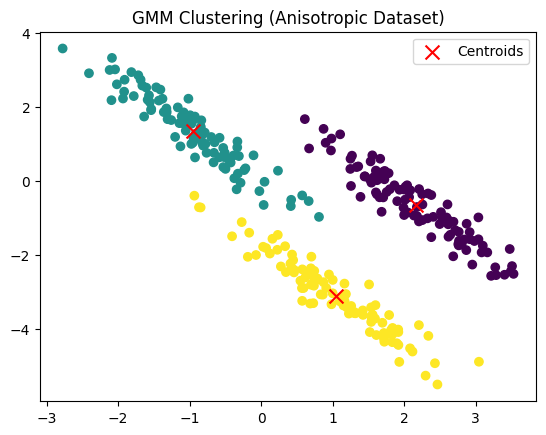

In [25]:
#GMM clustering for anisotropic dataset
gmm_anisotropic = GMM(n_components=3)
plot_gmm_clusters(gmm_anisotropic, X_anisotropic, 'GMM Clustering (Anisotropic Dataset)')

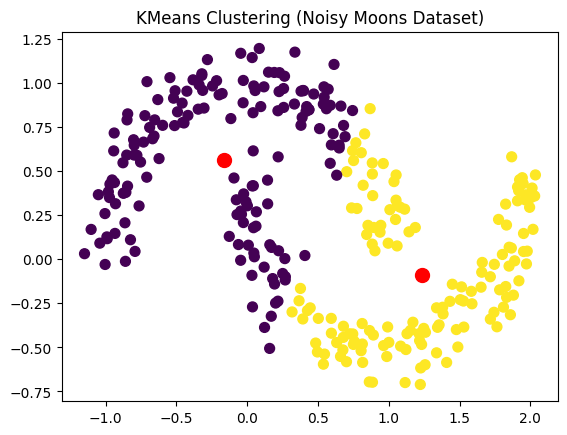

In [26]:
#Kmeans clustering for noisy moons dataset
kmeans_moons = KMeans(k=2, max_iter=100, plot_steps=False)
plot_kmeans_clusters(kmeans_moons, X_moons, 'KMeans Clustering (Noisy Moons Dataset)')

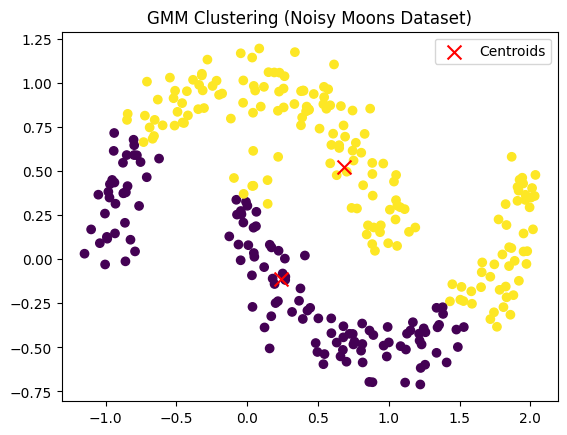

In [27]:
#GMM clustering for noisy moons dataset
gmm_moons = GMM(n_components=2)
plot_gmm_clusters(gmm_moons, X_moons, 'GMM Clustering (Noisy Moons Dataset)')

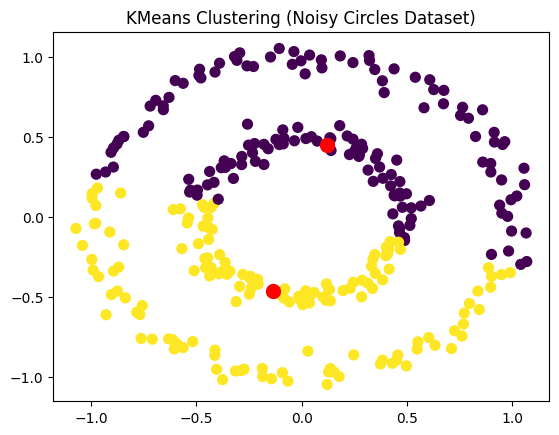

In [28]:
#Kmeans clustering for noisy circles dataset
kmeans_circles = KMeans(k=2, max_iter=100, plot_steps=False)
plot_kmeans_clusters(kmeans_circles, X_circles, 'KMeans Clustering (Noisy Circles Dataset)')

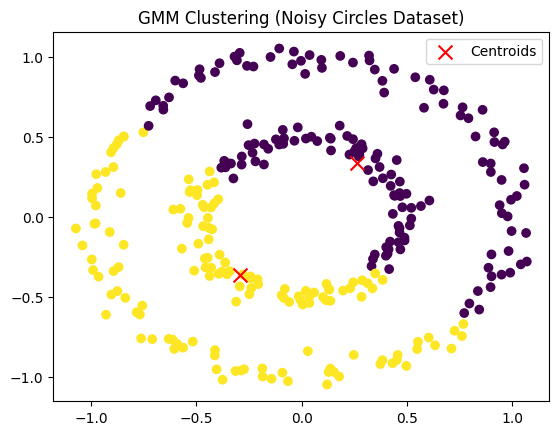

In [29]:
#GMM clustering for noisy circles dataset
gmm_circles = GMM(n_components=2)
plot_gmm_clusters(gmm_circles, X_circles, 'GMM Clustering (Noisy Circles Dataset)')

In [30]:
#Calculate measures sections
results = []

results.append(('Blobs', 'KMeans', *calculate_accuracy(y_blobs, kmeans_blobs.cluster_assignment_)))
results.append(('Blobs', 'GMM', *calculate_accuracy(y_blobs, gmm_blobs.predict(X_blobs))))

results.append(('Anisotropic', 'KMeans', *calculate_accuracy(np.zeros(n_samples), kmeans_anisotropic.cluster_assignment_)))
results.append(('Anisotropic', 'GMM', *calculate_accuracy(np.zeros(n_samples), gmm_anisotropic.predict(X_anisotropic))))

results.append(('Noisy Moons', 'KMeans', *calculate_accuracy(y_moons, kmeans_moons.cluster_assignment_)))
results.append(('Noisy Moons', 'GMM', *calculate_accuracy(y_moons, gmm_moons.predict(X_moons))))

results.append(('Noisy Circles', 'KMeans', *calculate_accuracy(y_circles, kmeans_circles.cluster_assignment_)))
results.append(('Noisy Circles', 'GMM', *calculate_accuracy(y_circles, gmm_circles.predict(X_circles))))

In [31]:
#Creating a dataframe to format the final output
columns = ['Dataset', 'Algorithm', 'F-Measure', 'NMI', 'Rand Statistic']
results_df = pd.DataFrame(results, columns=columns)

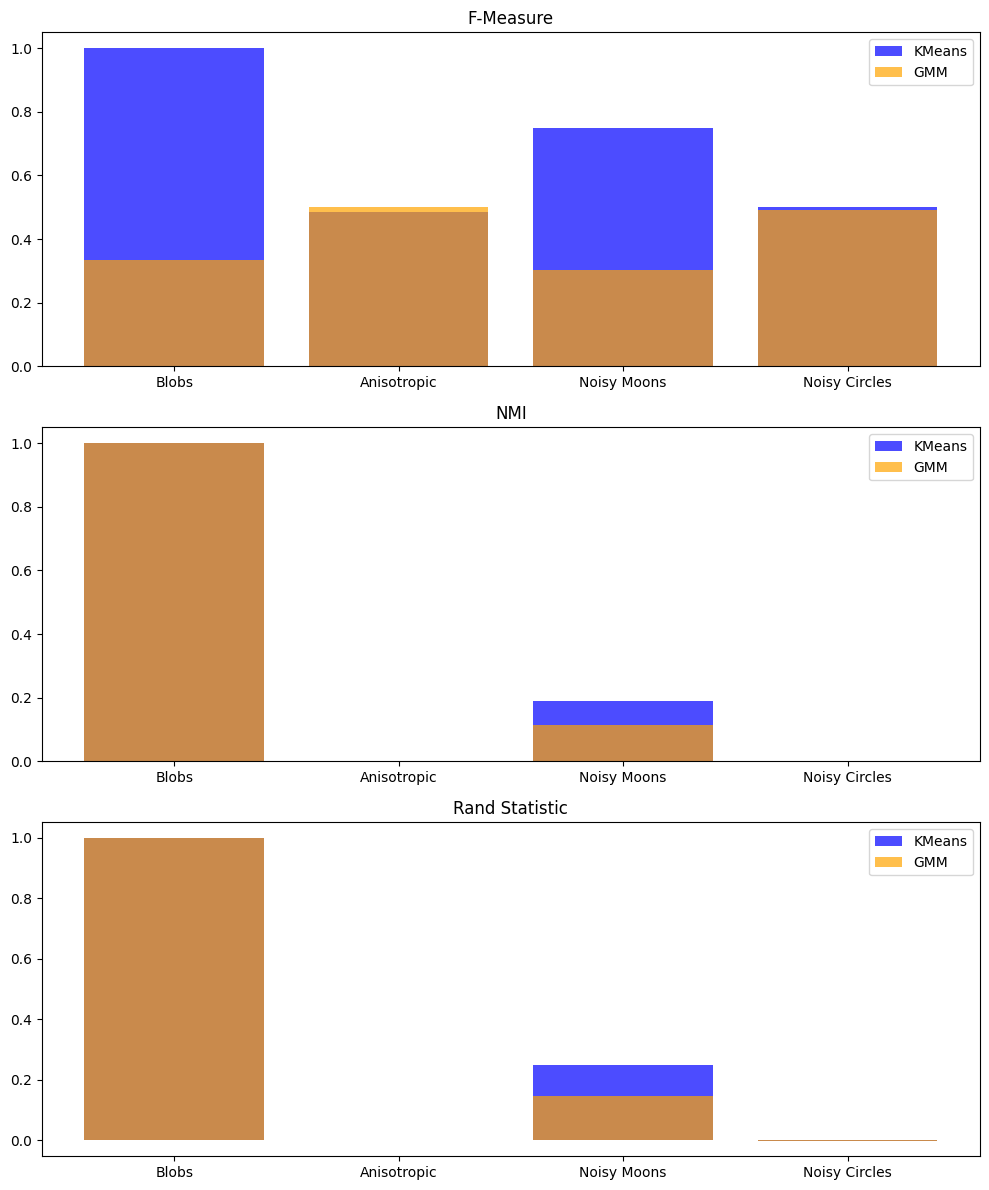

In [32]:
#Plotting to compare the results of the measures
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i, metric in enumerate(['F-Measure', 'NMI', 'Rand Statistic']):
    axes[i].bar(results_df[results_df['Algorithm'] == 'KMeans']['Dataset'], results_df[results_df['Algorithm'] == 'KMeans'][metric], label='KMeans', color='blue', alpha=0.7)
    axes[i].bar(results_df[results_df['Algorithm'] == 'GMM']['Dataset'], results_df[results_df['Algorithm'] == 'GMM'][metric], label='GMM', color='orange', alpha=0.7)
    axes[i].set_title(metric)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [33]:
#Printing the output of the dataframe which contains the results of the measures
print(results_df)

         Dataset Algorithm  F-Measure       NMI  Rand Statistic
0          Blobs    KMeans   1.000000  1.000000        1.000000
1          Blobs       GMM   0.333333  1.000000        1.000000
2    Anisotropic    KMeans   0.484848  0.000000        0.000000
3    Anisotropic       GMM   0.500000  0.000000        0.000000
4    Noisy Moons    KMeans   0.749775  0.189839        0.247492
5    Noisy Moons       GMM   0.302918  0.114408        0.146719
6  Noisy Circles    KMeans   0.499911  0.000000       -0.003353
7  Noisy Circles       GMM   0.489858  0.000289       -0.002951


In [ ]:
'''
Student names:
1- Khalid Nimri 2140145
2- Mohammed Allagany 2142374
3- Aseel Suhail 2140197
4- Rayan Bawazeer 2140362

'''